In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re
import requests
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ejfel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
with open('coffee_words.pickle','rb') as read_file:
    coffee = pickle.load(read_file)
with open('coffee_ratings.pickle','rb') as read_file:
    ratings = pickle.load(read_file)
with open('combined.pickle','rb') as read_file:
    combined = pickle.load(read_file)
with open('df_full.pickle','rb') as read_file:
    df = pickle.load(read_file)
with open('df_topic_breakdown.pickle','rb') as read_file:
    df_topic_breakdown = pickle.load(read_file)
with open('sentiment.pickle','rb') as read_file:
    sentiment = pickle.load(read_file)

with open('blindtfidf_vec.pickle', 'rb') as read_file:
    blindtfidf = pickle.load(read_file)
with open('blindtfidf_mat.pickle', 'rb') as read_file:
    tfidf_blind = pickle.load(read_file)

In [3]:
df = pd.DataFrame()
df['Roaster'] = coffee['Roaster']
df['TextA'] = coffee.Review + coffee.Notes + coffee.TLDR
df['TextB'] = df.TextA.str.replace('[^ ]+\.[^ ]+','',regex=True)
df['Text'] = df.TextB.str.replace(r'Visit.*\n?','',regex=True)
df.drop(columns=['TextA','TextB'],inplace=True)

In [5]:
# vectorize the corpus
count_vectorizer = CountVectorizer(min_df=10, max_df=3200, ngram_range=(1,1), stop_words='english')
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=3200, ngram_range=(1,1), stop_words='english')

# calculate the feature matrix
feature_matrix = count_vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(df.Text.str.replace(r'\d+','',regex=True))


## KMeans on ratings values for coffee reviews

In [28]:
combined.loc[(combined.aroma == 'NR')|(combined.aroma == 'NA'),'aroma'] = '-999'
combined.aroma = combined.aroma.astype(float)
combined.aroma = combined.aroma.round(0)

combined.loc[(combined.body == 'NR')|(combined.body == 'NA'),'body'] = '-999'
combined.body = combined.body.astype(float)
combined.body = combined.body.round(0)

combined.loc[(combined.flavor == 'NR')|(combined.flavor == 'NA'),'flavor'] = '-999'
combined.flavor = combined.flavor.astype(float)
combined.flavor = combined.flavor.round(0)

combined.aftertaste.fillna('-999',inplace=True)
combined.aftertaste = combined.aftertaste.astype(float)
combined.aftertaste = combined.aftertaste.round(0)

combined.loc[(combined.acidity == 'NR')|(combined.acidity == 'NA')|(combined.acidity == 'na')|(combined.acidity == 'n/a'),'acidity'] = '-999'
combined.loc[(combined.acidity == 'Very Low'),'acidity'] = '1'
combined.loc[(combined.acidity == 'Low'),'acidity'] = '3'
combined.loc[(combined.acidity == 'Moderate'),'acidity'] = '5'
combined.acidity.fillna(-999,inplace=True)
combined.acidity = combined.acidity.astype(float)
combined.acidity = combined.acidity.round(0)

combined.dropna(subset=['rating','aroma','body','flavor','aftertaste','acidity'],axis=0,inplace=True)
# pd.get_dummies(combined,columns=['group'])
combined.head()

C:\Users\ejfel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,roaster,origin,roast_level,group,rating,aroma,body,flavor,aftertaste,acidity
0,Jackrabbit Java,Costa Rica,Medium-Light,1,93,9.0,9.0,9.0,8.0,8.0
1,Jackrabbit Java,"Nyamasheke District, Rwanda",Medium-Light,0,92,9.0,8.0,9.0,8.0,8.0
2,Red Rooster Coffee Roaster,"Los Naranjos, La Argentina, Huila Department, ...",Light,0,96,9.0,9.0,10.0,9.0,9.0
3,Paradise Roasters,"Huila, Colombia",Light,0,95,9.0,9.0,9.0,9.0,9.0
4,Kakalove Cafe,"Antioquia Department, Colombia",Medium-Light,1,95,9.0,9.0,9.0,9.0,9.0


In [29]:
useful = combined[(combined.rating>0)&(combined.aroma>0)&(combined.body>0)&(combined.flavor>0)&(combined.aftertaste>0)&(combined.acidity>0)]


In [82]:
pca = PCA(2)
#Transform the data
data = pca.fit_transform(useful[['aroma','body','flavor','aftertaste','acidity']])
data.shape

(4099, 2)

In [83]:
pd.DataFrame(pca.components_,columns=['aroma','body','flavor','aftertaste','acidity'])

,aroma,body,flavor,aftertaste,acidity
0,-0.454642,-0.321863,-0.517563,-0.402763,-0.509524
1,-0.301783,-0.550669,-0.022352,0.777531,0.025222


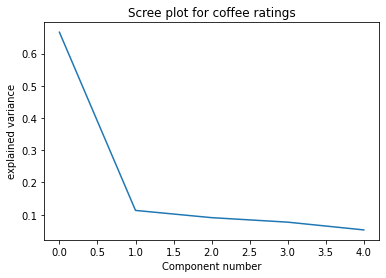

In [92]:
pca_scree = PCA(5)
#Transform the data
data_scree = pca_scree.fit_transform(useful[['aroma','body','flavor','aftertaste','acidity']])
data_scree.shape
plt.plot(pca_scree.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('explained variance');
plt.title('Scree plot for coffee ratings');

# Use two components for PCA

In [86]:
#Initialize the class object
kmeans = KMeans(n_clusters= 4)
 
#predict the labels of clusters.
label = kmeans.fit_predict(data)
 
print(label)

[1 0 1 ... 3 3 3]


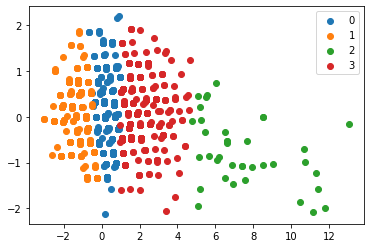

In [87]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.legend()
plt.show()

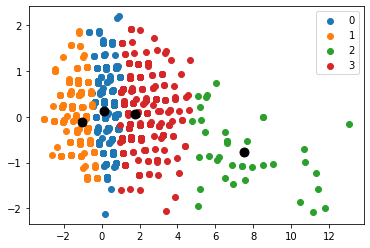

In [88]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## KMeans on CountVectorizer

In [58]:
pca = PCA(2)
#Transform the data
data = pca.fit_transform(feature_matrix.todense())
data.shape

(5959, 2)

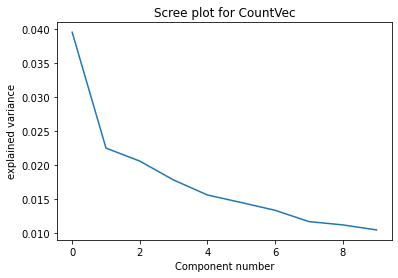

In [96]:
pca_scree = PCA(10)
#Transform the data
data_scree = pca_scree.fit_transform(feature_matrix.todense())
data_scree.shape
plt.plot(pca_scree.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('explained variance');
plt.title('Scree plot for CountVec');

# Use two, five, or eight components for PCA

In [59]:
#Initialize the class object
kmeans = KMeans(n_clusters= 10)
 
#predict the labels of clusters.
label = kmeans.fit_predict(data)
 
print(label)

[3 1 1 ... 3 3 3]


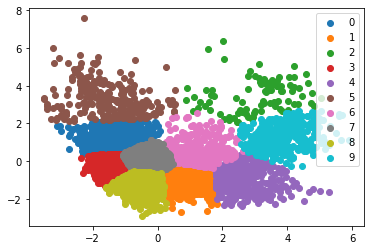

In [60]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.legend()
plt.show()

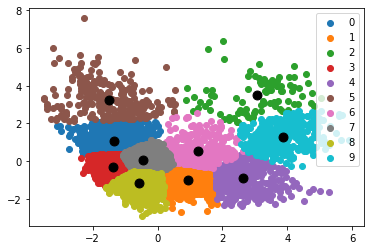

In [61]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## KMeans on TF-IDF

In [97]:
pca = PCA(4)
#Transform the data
data = pca.fit_transform(tfidf_feature_matrix.todense())
data.shape

(5959, 4)

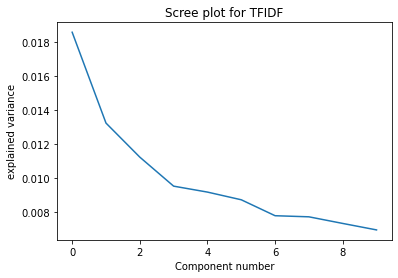

In [95]:
pca_scree = PCA(10)
#Transform the data
data_scree = pca_scree.fit_transform(tfidf_feature_matrix.todense())
data_scree.shape
plt.plot(pca_scree.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('explained variance');
plt.title('Scree plot for TFIDF');

# Use two, four, or seven components for PCA

In [98]:
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
 
#predict the labels of clusters.
label = kmeans.fit_predict(data)
 
print(label)

[0 2 2 ... 7 7 7]


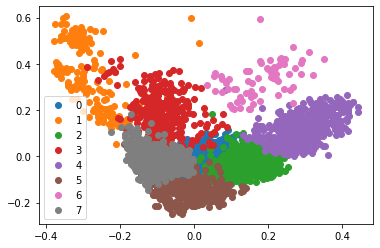

In [99]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.legend()
plt.show()

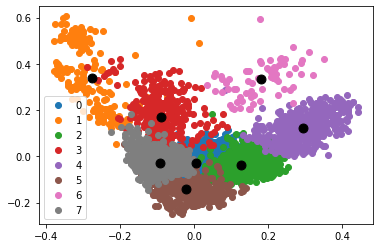

In [107]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()